In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import plotly 
import plotly.plotly as py 
import plotly.figure_factory as ff
from plotly.graph_objs import *
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import scipy.stats as stats
import math
from sklearn import linear_model
from sklearn.linear_model import SGDRegressor

In [2]:
monthlyAsylumSeekers = pd.read_csv("../data/refugee_monthly.csv", sep=",", engine='python', encoding ='latin1')   
monthlyAsylumSeekers = monthlyAsylumSeekers[monthlyAsylumSeekers['Value'] != '*']
monthlyAsylumSeekers['Value'] = monthlyAsylumSeekers['Value'].apply(pd.to_numeric)
monthlyAsylumSeekers.head()

,Country / territory of asylum/residence,Origin,Year,Month,Value
0,Greece,Georgia,2008,March,140
1,Greece,Georgia,2008,April,199
2,Greece,Georgia,2008,May,210
3,Greece,Georgia,2008,June,208
4,Greece,Georgia,2008,July,224


In [3]:
monthlyAsylumSeekers.sort_values(by=['Year'])
monthlyAsylumSeekers.rename(columns={'Country / territory of asylum/residence':'CountryofAsylum'}, inplace=True)
monthlyAsylumSeekers.head()

,CountryofAsylum,Origin,Year,Month,Value
0,Greece,Georgia,2008,March,140
1,Greece,Georgia,2008,April,199
2,Greece,Georgia,2008,May,210
3,Greece,Georgia,2008,June,208
4,Greece,Georgia,2008,July,224


In [4]:
def cleanDataSets(df):
    # dropping empty rows 
    df2=df.dropna(subset=['1990','1991','1992','1993','1994','1995','1996','1997','1998','1999','2000','2001','2002',
                 '2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016'], 
                  how='all')
    # dropping empty columns 
    df3=df2.dropna(axis=1, how='all')
    df4=df3.drop('Indicator Code',axis=1)
    df5=df4.drop('Indicator Name',axis=1)
    return df5

In [5]:
GDPByCountry = pd.read_csv("../data/GDP/GDP.csv", sep='\t', engine='python', encoding ='latin1') 
GDP=cleanDataSets(GDPByCountry)
GDP.drop(GDP.columns[[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
                      31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58]], axis=1, inplace=True)
#GDP.rename_axis("Country Name", axis="columns", inplace=True)
#GDP=GDP.rename_axis('Country Name', axis=1,inplace=True)
#del(GDP.index["Country Name"])
#data.set_index('Locality', inplace=True)
GDP.head()

,Country Name,Country Code
0,Aruba,ABW
1,Afghanistan,AFG
2,Angola,AGO
3,Albania,ALB
4,Andorra,AND


Rename to make merge easier

In [6]:
GDP.rename(columns={'Country Name':'CountryofAsylum'}, inplace=True)
GDP.head()

,CountryofAsylum,Country Code
0,Aruba,ABW
1,Afghanistan,AFG
2,Angola,AGO
3,Albania,ALB
4,Andorra,AND


Join for aslyum country code

In [7]:
Combined=monthlyAsylumSeekers.merge(GDP,on='CountryofAsylum', how='inner')
Combined.rename(columns={'Country Code':'CountryCodeAsylum'}, inplace=True)
Combined.head()

,CountryofAsylum,Origin,Year,Month,Value,CountryCodeAsylum
0,Greece,Georgia,2008,March,140,GRC
1,Greece,Georgia,2008,April,199,GRC
2,Greece,Georgia,2008,May,210,GRC
3,Greece,Georgia,2008,June,208,GRC
4,Greece,Georgia,2008,July,224,GRC


Rename to make merge (for origin country code) easier

In [8]:
GDP.rename(columns={'CountryofAsylum':'Origin'}, inplace=True)
GDP.head()

,Origin,Country Code
0,Aruba,ABW
1,Afghanistan,AFG
2,Angola,AGO
3,Albania,ALB
4,Andorra,AND


Now merge for origin country code

In [9]:
Combined=Combined.merge(GDP,on='Origin', how='inner')
Combined.rename(columns={'Country Code':'CountryCodeOrigin'}, inplace=True)
Combined.head()

,CountryofAsylum,Origin,Year,Month,Value,CountryCodeAsylum,CountryCodeOrigin
0,Greece,Georgia,2008,March,140,GRC,GEO
1,Greece,Georgia,2008,April,199,GRC,GEO
2,Greece,Georgia,2008,May,210,GRC,GEO
3,Greece,Georgia,2008,June,208,GRC,GEO
4,Greece,Georgia,2008,July,224,GRC,GEO


##### Now that we have the country codes for origin and asylum we can easily merge with the distance data set

In [10]:
capitalDistance= pd.read_csv("../data/capdist.csv", sep=',', engine='python', encoding ='latin1') 
capitalDistance.drop(capitalDistance.columns[[0,2,5]], axis=1, inplace=True)
capitalDistance.head()

,ida,idb,kmdist
0,USA,CAN,731
1,USA,BHM,1623
2,USA,CUB,1813
3,USA,HAI,2286
4,USA,DOM,2358


rename ida to CountryCodeAsylum and idb to CountryCodeOrigin to make merging easier

In [11]:
capitalDistance.rename(columns={'ida':'CountryCodeAsylum','idb':'CountryCodeOrigin'}, inplace=True)
capitalDistance.head()

,CountryCodeAsylum,CountryCodeOrigin,kmdist
0,USA,CAN,731
1,USA,BHM,1623
2,USA,CUB,1813
3,USA,HAI,2286
4,USA,DOM,2358


In [12]:
final=Combined.merge(capitalDistance, on=['CountryCodeAsylum', 'CountryCodeOrigin'], how='inner')
final.head()

,CountryofAsylum,Origin,Year,Month,Value,CountryCodeAsylum,CountryCodeOrigin,kmdist
0,Greece,Ghana,2001,February,1,GRC,GHA,4365
1,Greece,Ghana,2001,November,1,GRC,GHA,4365
2,Greece,Ghana,2001,December,5,GRC,GHA,4365
3,Greece,Ghana,2002,January,1,GRC,GHA,4365
4,Greece,Ghana,2002,August,1,GRC,GHA,4365


Label encoders can be used to transform categorical data into numeral and back. This is useful for using regression on categorical data

In [13]:
from sklearn import preprocessing
countryTrainer=preprocessing.LabelEncoder()
originTrainer=preprocessing.LabelEncoder()
monthTrainer=preprocessing.LabelEncoder()

Transform categorical columns into numerical

In [14]:
final['CountryofAsylum']=countryTrainer.fit_transform(final['CountryofAsylum'])
final['Month']=monthTrainer.fit_transform(final['Month'])
final['Origin']=originTrainer.fit_transform(final['Origin'])
final[['CountryofAsylum','Origin', 'Month']].head()

,CountryofAsylum,Origin,Month
0,7,29,3
1,7,29,9
2,7,29,2
3,7,29,4
4,7,29,1


In [82]:
from sklearn.utils import shuffle
final = shuffle(final)
final.head()

,CountryofAsylum,Origin,Year,Month,Value,CountryCodeAsylum,CountryCodeOrigin,kmdist
19086,15,71,2010,10,2,POL,UKR,688
41545,3,36,2012,2,6,CAN,ISR,8926
37379,6,35,2011,9,40,FIN,IRQ,3322
898,10,29,2013,9,9,JPN,GHA,13870
29458,14,19,2013,0,1,NOR,DJI,5934


Test to see if it works

In [16]:
print monthTrainer.inverse_transform([0,1,2,3,4,5,6,7,8,9,10,11])
print monthTrainer.transform(['March','April','May'])
print countryTrainer.transform(['Greece'])
print originTrainer.transform(['Ghana'])

[u'April' u'August' u'December' u'February' u'January' u'July' u'June'
 u'March' u'May' u'November' u'October' u'September']
[7 0 8]
[7]
[29]


Gonna try SGD classifier first so y needs to be categorical country of asylum

In [17]:
X=final[['Value','Origin','Month', 'kmdist']]
y=final['CountryofAsylum']
X.head()

,Value,Origin,Month,kmdist
25131,11,34,9,5613
65177,10,48,7,1424
13935,43,68,9,2542
65366,4,48,1,7134
8910,124,14,1,7529


Test linear regression (not important, but wanted to see)

In [27]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.5, random_state=0)
X_train.shape, X_test.shape

((34309, 4), (34310, 4))

SGDClassifier to predict where a country of asylum based on value, month, and country of origin

In [28]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("{0} / {1} correct".format(np.sum(y_test == y_pred), len(y_test)))

33796 / 34310 correct


Test

In [29]:
clf.predict([[100,originTrainer.transform(['Ghana'])[0],monthTrainer.transform(['April'])[0],3000]])

array([9], dtype=int64)

In [24]:
print countryTrainer.inverse_transform(3)

Canada


In [30]:
from sklearn.cross_validation import cross_val_score
cv = cross_val_score(KNeighborsClassifier(), X, y, cv=10)
cv.mean()

0.99148933467302047

In [51]:
from sklearn.model_selection import learning_curve
from

train_sizes, train_scores, valid_scores = learning_curve(KNeighborsClassifier(), X, y, train_sizes=[27000, 22000, 19619], cv=5)

In [52]:
valid_scores

array([[ 0.97763858,  0.97734062,  0.97406004,  0.97770167,  0.97608981],
       [ 0.98026076,  0.97930783,  0.9772661 ,  0.98047074,  0.97893279],
       [ 0.98244592,  0.98156648,  0.9806179 ,  0.98309408,  0.98155708]])

http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

In [53]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

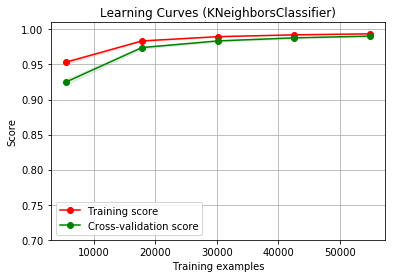

In [84]:
from sklearn.model_selection import ShuffleSplit
title = "Learning Curves (KNeighborsClassifier)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = KNeighborsClassifier()

plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

Validation

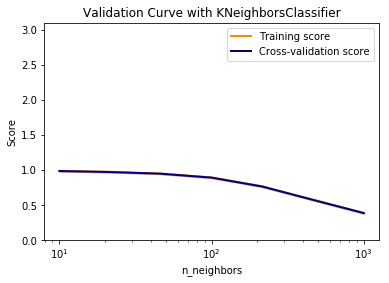

In [70]:
from sklearn.model_selection import validation_curve
param_range = np.logspace(1, 3, 7, dtype='i4')
train_scores, test_scores = validation_curve(
    KNeighborsClassifier(n_neighbors=10, weights='uniform'), X, y, param_name="n_neighbors", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with KNeighborsClassifier")
plt.xlabel("n_neighbors")
plt.ylabel("Score")
plt.ylim(0.0, 3.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [71]:
param_range = np.logspace(1, 3, 7, dtype='i4')
train_scores, test_scores = validation_curve(
    KNeighborsClassifier(n_neighbors=10, weights='uniform'), X, y, param_name="n_neighbors", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=1)

KeyboardInterrupt: 

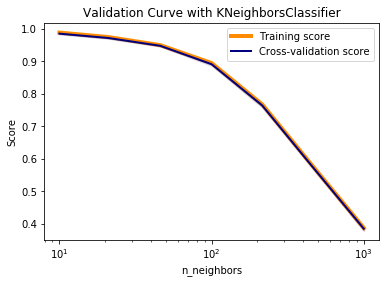

In [86]:
plt.title("Validation Curve with KNeighborsClassifier")
plt.xlabel("n_neighbors")
plt.ylabel("Score")
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=4)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()
